In [2]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath("../Instruments"))
import numpy as np
from ETF import ETF
from Future import Future
from Treasury import Treasury
from Portfolio import Portfolio
from risk_free_rate import get_risk_free_rate
import warnings
import DateRanges as dr
import sys
import os
sys.path.append(os.path.abspath("../FixedIncomeAnalysis"))
import FixedIncomeAnalysisClass as FI
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Portfolio With All Collected Assets

In [2]:
SPY = ETF("SPY")
XLB = ETF("XLB")
XLF = ETF("XLF")
XLP = ETF("XLP")
XLY = ETF("XLY")
XLE = ETF("XLE")
XLI = ETF("XLI")
XLK = ETF("XLK")
XLU = ETF("XLU")
XLV = ETF("XLV")

ES1 = Future("ES1")
DX1 = Future("DX1")
SI1 = Future("SI1")
CL1 = Future("CL1")
NG1 = Future("NG1")
GC1 = Future("GC1")
DBC = ETF("DBC")

sixMo = Treasury("0.5")
oneYr = Treasury("1.0")
twoYr = Treasury("2.0")
threeYr = Treasury("3.0")
fiveYr = Treasury("5.0")
sevenYr = Treasury("7.0")
tenYr = Treasury("10.0")
thirtyYr = Treasury("30.0")

all_securities = [XLB, XLF, XLP, XLY, XLE, XLI, XLK, XLU, XLV, ES1, DX1, SI1, CL1, NG1, GC1, sixMo, oneYr, twoYr, threeYr, fiveYr, sevenYr, 
                  thirtyYr]


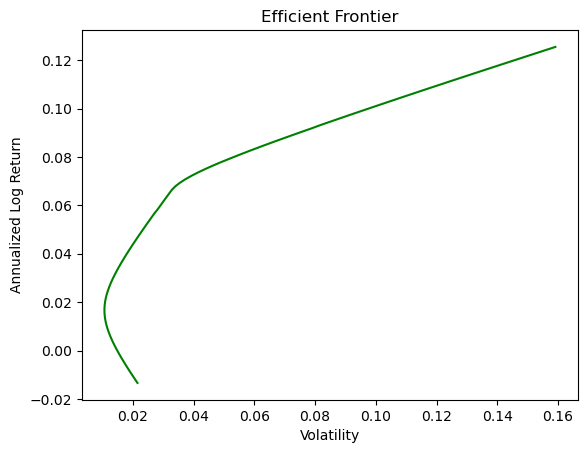

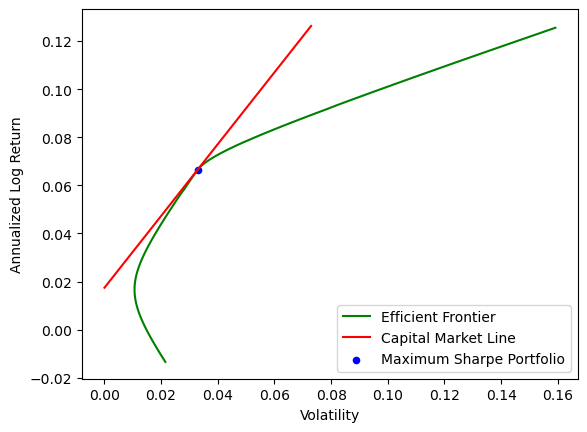

In [3]:
portfolio = Portfolio(all_securities, rf = get_risk_free_rate('2008-05-06'), equity_benchmark = SPY, future_benchmark = DBC,treasury_benchmark = tenYr)
portfolio.filter(startDate="2008-01-01", endDate="2024-01-01", period=1)
max_sharpe_ratio, ret, vol, weights = portfolio.plot_ef(n_points = 100)


In [4]:
print("MSR portfolio weights: " + str(weights))
print("MSR portfolio expected annualized log return: " + str(ret))
print("MSR portfolio annualized volatility of log returns: " + str(vol))
print("Sharpe Ratio of Portfolio: "+str(max_sharpe_ratio))
print("MSR portfolio VaR: "+str(portfolio.portfolio_VaR(weights)))
print("MSR portfolio ES: "+str(portfolio.portfolio_ES(weights)))
print()

MSR portfolio weights: [ 0.05747567  0.06060039  0.01188873  0.01713105  0.03400959  0.02963545
  0.18389665  0.06062753  0.11515527 -0.5         0.10176759  0.01820585
 -0.0049059   0.00459659 -0.0089283   0.5         0.5         0.06616589
 -0.19197973 -0.14924115  0.08982279  0.00407605]
MSR portfolio expected annualized log return: 0.06659355116440015
MSR portfolio annualized volatility of log returns: 0.03292715755832941
Sharpe Ratio of Portfolio: 1.4925867036538985
MSR portfolio VaR: 0.0541603545350207
MSR portfolio ES: 0.06791926961038107



In [5]:
# Filters data to only 2024 election cycle
portfolio.filter(startDate="2024-01-01", endDate="2025-01-01", period=1)
portfolio.set_rf(get_risk_free_rate('2024-05-07'))
# See how the calculated weights using data up to and including 2020 election would have worked
# for the 2024 election
print("2024 election period actual annualized log returns: " + str(portfolio.historical_annualized_log_return(weights)))

# Filters data to May 5 to November 17 of 2023 (6.5 month period of a non-election year)
portfolio.filter(startDate="2023-05-05", endDate="2023-11-17", period=-1)
portfolio.set_rf(get_risk_free_rate('2023-05-05'))
print("2023 May 5 to November 17 actual annualized log returns: " +  str(portfolio.historical_annualized_log_return(weights)))

# Filters data to May 6 to November 18 of 2022 (6.5 month period of a non-election year)
portfolio.filter(startDate="2022-05-06", endDate="2022-11-18", period=-1)
portfolio.set_rf(get_risk_free_rate('2022-05-06'))
print("2022 May 6 to November 18 actual annualized log returns: " +  str(portfolio.historical_annualized_log_return(weights)))

# Filters data to May 7 to November 19 of 2021 (6.5 month period of a non-election year)
portfolio.filter(startDate="2021-05-07", endDate="2021-11-19", period=-1)
portfolio.set_rf(get_risk_free_rate('2021-05-07'))
print("2021 May 7 to November 19 actual annualized log returns: " +  str(portfolio.historical_annualized_log_return(weights)))

2024 election period actual annualized log returns: -0.013880618555375014
2023 May 5 to November 17 actual annualized log returns: 0.014089559128993663
2022 May 6 to November 18 actual annualized log returns: 0.030501735720290413
2021 May 7 to November 19 actual annualized log returns: 0.02755061645762303


# Calculating the Duration and convexity of the portfolio

In [6]:
treasury_weights = weights[-8:]

# %%
treasury_curves = pd.read_csv("../Data/TreasuryData/Cleaned-Data/cleaned_treasury_data.csv").set_index("Date")
treasury_curves.index = pd.to_datetime(treasury_curves.index)

# %%
treasuries_2024 = treasury_curves[treasury_curves.index == dr.e_year_ranges["2024"][0]]

# Renaming the dataframe and sorting
name_map = {}
for name in treasuries_2024.columns:
    year = int(name.split()[0])
    if name.split()[1] == "Mo":
        year /= 12

    name_map[name] = year

treasuries_2024.rename(columns=name_map,inplace=True)

durations = treasuries_2024.apply(lambda x : FI.Treasuries(x, x.name, issue_date=x.index).modified_duration())
convexities = treasuries_2024.apply(lambda x : FI.Treasuries(x, x.name, issue_date=x.index).convexity())

# %%
duration = durations.dot(treasury_weights)
convexity = convexities.dot(treasury_weights)

/var/folders/49/1jq9sd950fg6397s7sm972380000gn/T/ipykernel_31955/1092453778.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treasuries_2024.rename(columns=name_map,inplace=True)


In [9]:
treasury_weights[-8:]

array([-0.0089283 ,  0.5       ,  0.5       ,  0.06616589, -0.19197973,
       -0.14924115,  0.08982279,  0.00407605])

In [7]:
duration

Date
2024-05-07    0.646788
dtype: float64

In [8]:
convexity

Date
2024-05-07    1.3471
dtype: float64